# Autores

Hellen Rakel Palma Enrique

Maria Adelaida Suarez Restrepo


# Librerias y estaticos

In [ ]:
# Manejo archivos
# ==============================================================================
import os
from os import listdir, path
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


In [ ]:
# Conexion con Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import de funciones
# ==============================================================================
import sys
sys.path.append('/content/drive/MyDrive/monografia/utils')
from funciones import multiple_plot

In [ ]:
path_df = '/content/drive/MyDrive/monografia/dataset/dataset_base.csv'
path_df1 = '/content/drive/MyDrive/monografia/dataset/dataset_base1.csv'

#Datos originales

##Tablas eventos

In [ ]:
# Concatenamos tablas eventos
#(posible volcamiento, giro brusco,frenada brusca, aceleración brusca, posible accidente, exceso de velocidad prolongada)
# ==============================================================================
ruta_eventos = '/content/drive/MyDrive/monografia/Tablas/eventos'
df_eventos = pd.DataFrame()
for i, df in enumerate([pd.read_csv(path.join(ruta_eventos, file), sep=';') for file in listdir(ruta_eventos)]):
    # Concatenar DataFrames
    if i == 0:
        df_eventos = df
    else:
        df_eventos = pd.concat([df_eventos, df], axis=0)

df_eventos.reset_index(drop=True)
print(df_eventos.shape)
df_eventos.info()

(152042, 38)
<class 'pandas.core.frame.DataFrame'>
Index: 152042 entries, 0 to 59841
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Address                  152028 non-null  object 
 1   Altitude                 152042 non-null  int64  
 2   CompanyId                152042 non-null  int64  
 3   CompanyName              152042 non-null  object 
 4   CustomerId               152042 non-null  int64  
 5   CustomerName             152042 non-null  object 
 6   DateTimeUTC              152042 non-null  object 
 7   DisplayName              152042 non-null  object 
 8   EngineStatus             152042 non-null  bool   
 9   EventDetail              535 non-null     object 
 10  EventLogId               152042 non-null  int64  
 11  EventTypeId              152042 non-null  int64  
 12  EventTypeName            152042 non-null  object 
 13  EventValue               76851 non-null   object 
 1

In [ ]:
# Conservamos los eventos de los tractocamiones (flota en estudio)
# ==============================================================================
df_eventos = df_eventos[df_eventos['VehicleTypeName'] == "TRACTOCAMION"]
df_eventos = df_eventos[df_eventos['CompanyName'].str.contains("T1", na=False)]
df_eventos.shape

(149573, 38)

In [ ]:
# Conseguimos el alias para el conductor
# ==============================================================================
df_eventos = df_eventos.dropna(subset=['EventValue'])
df_eventos['CC'] = df_eventos['EventValue'].str.split(' - ').str[-1].str.strip()
df_eventos['Driver'] = df_eventos['EventValue'].apply(lambda x: (str(x.split(' - ')[-1]) + str(x.split(' - ')[0][-2:])))
df_eventos.shape

(76850, 40)

In [ ]:
# Creamos variables y llaves necesarias
# ==============================================================================
df_eventos['DateTimeUTC'] = pd.to_datetime(df_eventos['DateTimeUTC'], errors='coerce')

# df_eventos['fecha_h_ev'] = df_eventos['DateTimeUTC'].dt.date.astype(str)+ df_eventos['DateTimeUTC'].dt.floor('H').dt.time.astype(str)
df_eventos['fecha_h_ev'] = df_eventos['DateTimeUTC'].dt.date.astype(str)

df_eventos['llave'] = df_eventos['fecha_h_ev'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()
df_eventos.shape

(76850, 42)

In [ ]:
# # Eliminamos registros duplicados según llave_event, para mantener el primer evento
# # ==============================================================================
'''
df_eventos['fecha_h_ev1'] = df_eventos['DateTimeUTC'].dt.date.astype(str)+ df_eventos['DateTimeUTC'].dt.floor('H').dt.time.astype(str)

df_eventos['llave1'] = df_eventos['fecha_h_ev1'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()
df_eventos['llave_event'] = df_eventos['llave1'] + df_eventos['EventTypeName']

df_eventos = df_eventos.sort_values(by=['llave_event', 'DateTimeUTC'])
df_eventos = df_eventos.drop_duplicates(subset='llave_event', keep='first')

df_eventos.shape
'''

"\ndf_eventos['fecha_h_ev1'] = df_eventos['DateTimeUTC'].dt.date.astype(str)+ df_eventos['DateTimeUTC'].dt.floor('H').dt.time.astype(str)\n\ndf_eventos['llave1'] = df_eventos['fecha_h_ev1'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()\ndf_eventos['llave_event'] = df_eventos['llave1'] + df_eventos['EventTypeName']\n\ndf_eventos = df_eventos.sort_values(by=['llave_event', 'DateTimeUTC'])\ndf_eventos = df_eventos.drop_duplicates(subset='llave_event', keep='first')\n\ndf_eventos.shape\n"

In [ ]:
# Eliminamos variables basura
# ==============================================================================
cols_a_eliminar = df_eventos.columns[[
0,2,3,4,5,9,10,11,13,14,16,17,18,21,22,24,25,27,28,29,30,31,32,33,34,35,36,38,40
]]

print(df_eventos.columns)

# Eliminar variables especificadas
df_event = df_eventos.drop(columns=cols_a_eliminar)
print(df_event.shape)
df_event.info()

Index(['Address', 'Altitude', 'CompanyId', 'CompanyName', 'CustomerId',
       'CustomerName', 'DateTimeUTC', 'DisplayName', 'EngineStatus',
       'EventDetail', 'EventLogId', 'EventTypeId', 'EventTypeName',
       'EventValue', 'FleetId', 'FleetName', 'GeoReferenceName',
       'GeoReferenceTypeId', 'GeoReferenceTypeName', 'Latitude', 'Longitude',
       'Odometer', 'SaveDate', 'Speed', 'TrackingId', 'VehicleBrandId',
       'VehicleBrandName', 'VehicleFilterFieldId1', 'VehicleFilterFieldId2',
       'VehicleFilterFieldText1', 'VehicleFilterFieldText2', 'VehicleId',
       'VehicleInternalName', 'VehicleModelId', 'VehicleModelName',
       'VehiclePlate', 'VehicleTypeId', 'VehicleTypeName', 'CC', 'Driver',
       'fecha_h_ev', 'llave'],
      dtype='object')
(76850, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 76850 entries, 0 to 59841
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----          

##Tabla Incidentes

In [ ]:
# Importamos tabla incidentes
# ==============================================================================
df_incidentes = pd.read_excel(path.join('/content/drive/MyDrive/monografia/Tablas/Incidentes.xlsx'))
print(df_incidentes.shape)
df_incidentes.info()

(623, 52)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PartitionKey             623 non-null    int64         
 1   RowKey                   623 non-null    int64         
 2   Timestamp                623 non-null    datetime64[ns]
 3   AccidentTypeId           623 non-null    int64         
 4   AccidentTypeName         623 non-null    object        
 5   Address                  623 non-null    object        
 6   AffectedVictimTypeId     623 non-null    int64         
 7   AffectedVictimTypeName   623 non-null    object        
 8   AffectedWoundedTypeId    623 non-null    int64         
 9   AffectedWoundedTypeName  623 non-null    object        
 10  AreaId                   623 non-null    int64         
 11  AreaName                 623 non-null    object        
 12  ArrivalDepartmentId      6

In [ ]:
# Conservamos T1-PRIMARIA (flota en estudio)
# ==============================================================================
df_incidentes = df_incidentes[df_incidentes['CompanyName'].str.contains("T1", na=False)]
df_incidentes.shape

(622, 52)

In [ ]:
# Creamos variables y llaves necesarias
# ==============================================================================
df_incidentes['fecha_inc'] = df_incidentes['SaveDate'].dt.date.astype(str)

#df_incidentes['fecha_inc'] =df_incidentes['SaveDate'].dt.date.astype
df_incidentes['llave'] = df_incidentes['fecha_inc'].astype(str).str.strip() +df_incidentes['VehiclePlate'].str.strip() + df_incidentes['DriverDocument'].str.strip()
df_incidentes.shape
df_incidentes['llave']

,llave
0,2024-10-07LGU6061098709817
1,2024-10-06KSP25679210573
2,2024-10-05LKO4471032357480
3,2024-10-05LKO42479468807
4,2024-10-05LGU59091344496
...,...
618,2024-01-03KSP2541073160578
619,2024-01-02LPR2171060588876
620,2024-01-02KVW19679840732
621,2024-01-02SZX10180176792


In [ ]:
# Eliminamos variables basura de incidentes
# ==============================================================================
cols_a_eliminar = df_incidentes.columns[[
0,1,2,3,4,5,6,8,10,11,12,14,16,17,18,19,21,23,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52
]]

# Eliminar variables especificadas
df_incidents = df_incidentes.drop(columns=cols_a_eliminar)
print(df_incidents.shape)
df_incidents.info()

(622, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, 0 to 622
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   AffectedVictimTypeName   622 non-null    object
 1   AffectedWoundedTypeName  622 non-null    object
 2   ArrivalDepartmentName    622 non-null    object
 3   ArrivalTownName          622 non-null    object
 4   DepartmentName           622 non-null    object
 5   DepartureDepartmentName  622 non-null    object
 6   DepartureTownName        622 non-null    object
 7   FatalitiesQuantity       622 non-null    int64 
 8   WoundedQuantity          622 non-null    int64 
 9   llave                    622 non-null    object
dtypes: int64(2), object(8)
memory usage: 53.5+ KB


#Dataset

Este dataset, creado a partir de datos de telemetria de una flota de carga, contiene información sobre eventos y accidentes en los viajes, y lo diseñamos con el objetivo analizar como predecir accidentes viales. Este conjunto de datos contiene tanto variables categóricas como numéricas, lo que permite explorar una variedad de factores que influyen en un accidente.

Por restricciones de privacidad no se otorga acceso a datos crudos.

https://drive.google.com/drive/folders/1E4CZE89iY9uu_N5pj9Gl2EKt7sYUBNz3?usp=sharing


##Eventos e incidentes

In [ ]:
# Cruzamos eventos e incidentes
# ==============================================================================
dataset = pd.merge(df_event, df_incidents, on='llave', how='left')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76904 entries, 0 to 76903
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Altitude                 76904 non-null  int64              
 1   DateTimeUTC              76902 non-null  datetime64[ns, UTC]
 2   DisplayName              76904 non-null  object             
 3   EngineStatus             76904 non-null  bool               
 4   EventTypeName            76904 non-null  object             
 5   FleetName                76904 non-null  object             
 6   Latitude                 76904 non-null  float64            
 7   Longitude                76904 non-null  float64            
 8   Speed                    76904 non-null  int64              
 9   VehicleBrandName         76904 non-null  object             
 10  VehicleTypeName          76904 non-null  object             
 11  Driver                   769

In [ ]:
# Creamos la variable de salida
# ==============================================================================
dataset['hasAccident'] = dataset['ArrivalTownName'].notna()

In [ ]:
# Ajustamos los campos para los eventos que no resultaron en accidente
# ==============================================================================
for column in df_incidents.columns:
  if column not in ['FatalitiesQuantity', 'WoundedQuantity']:
    dataset[column] = dataset[column].fillna('NA')
  else:
    dataset[column] = dataset[column].fillna(0)

dataset = dataset.drop(columns=['llave'])

In [ ]:
# Guardamos dataset
dataset.to_csv('/content/drive/MyDrive/monografia/dataset/dataset_base.csv', sep=';', index=False)

#Análisis descriptivo

Se relacionan las rutas de acceso a los archivos y funciones necesarias, previamente compartidos con david.villanueva@udea.edu.co

df = https://drive.google.com/drive/u/0/folders/1VnvMHeTpsn7CujCmsV-qHCtYtIe-aa6n

funciones = https://drive.google.com/drive/u/0/folders/1gQvOmOBtBmVnlIptvsLqxzhKB8pAhyHQ

In [ ]:
df = pd.read_csv(path_df, sep=';')
df['hasAccidentNum'] = df['hasAccident'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76904 entries, 0 to 76903
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Altitude                 76904 non-null  int64  
 1   DateTimeUTC              76902 non-null  object 
 2   DisplayName              76904 non-null  object 
 3   EngineStatus             76904 non-null  bool   
 4   EventTypeName            76904 non-null  object 
 5   FleetName                76904 non-null  object 
 6   Latitude                 76904 non-null  float64
 7   Longitude                76904 non-null  float64
 8   Speed                    76904 non-null  int64  
 9   VehicleBrandName         76904 non-null  object 
 10  VehicleTypeName          76904 non-null  object 
 11  Driver                   76904 non-null  object 
 12  AffectedVictimTypeName   475 non-null    object 
 13  AffectedWoundedTypeName  475 non-null    object 
 14  ArrivalDepartmentName 

In [ ]:
df.describe()

,Altitude,Latitude,Longitude,Speed,FatalitiesQuantity,WoundedQuantity,hasAccidentNum
count,76904.000000,76904.000000,76904.000000,76904.000000,76904.000000,76904.000000,76904.000000
mean,1387.195087,5.656143,-74.728949,38.697467,0.000065,0.000234,0.006177
std,918.708357,1.926430,1.093981,21.689102,0.008063,0.015297,0.078348
min,0.000000,0.856520,-77.582720,0.000000,0.000000,0.000000,0.000000
25%,591.750000,4.529270,-75.576770,18.000000,0.000000,0.000000,0.000000
50%,1275.000000,5.063170,-74.742115,42.000000,0.000000,0.000000,0.000000
75%,2411.250000,6.697983,-74.067878,56.000000,0.000000,0.000000,0.000000
max,3873.000000,11.545350,-72.264650,111.000000,1.000000,1.000000,1.000000


In [ ]:
# Ajustamos los campos para los eventos que no resultaron en accidente
# ==============================================================================

# df = df.fillna('NA')

In [ ]:
#Listado de Variables Categoricas
catCols = df.select_dtypes(include = ["object", 'category', 'string']).columns.tolist()

#Listado Variables numericas
numCols=df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()

/content/drive/MyDrive/monografia/utils/funciones.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)
/content/drive/MyDrive/monografia/utils/funciones.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cond.set_xticklabels

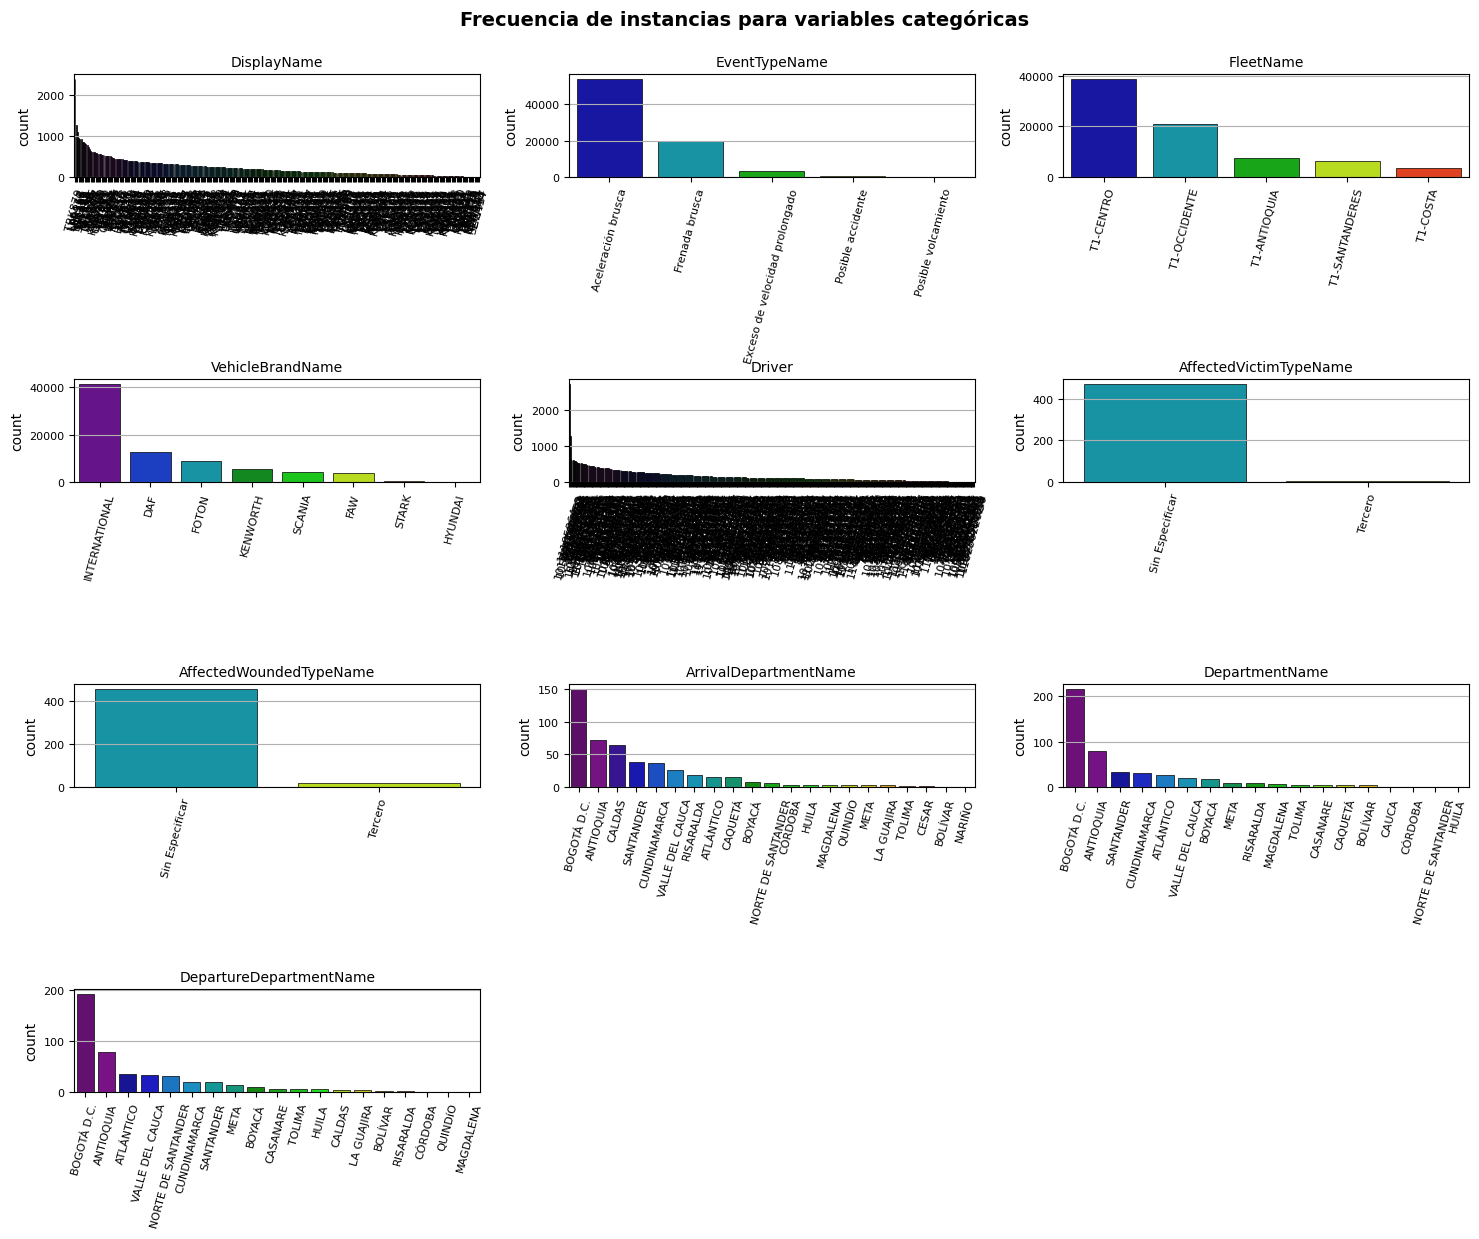

In [ ]:
# Visualización de frecuencia de instancias para variables categóricas
# ==============================================================================
fiels_large = ['DepartureTownName', 'ArrivalTownName', 'DateTimeUTC', 'VehicleTypeName']
cols = [col for col in catCols if col not in fiels_large]
multiple_plot(3, df, cols, None, 'countplot', 'Frecuencia de instancias para variables categóricas', 75)

Necesitamos mas datos, inicialmente tomamos tres (julio-septiembre 2024) meses pero evidenciamos categorias ausentes.

In [ ]:
# Distribución de cada variable categórica en el conjunto de datos
# ==============================================================================
for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(df[col].value_counts())
    print()

===== DateTimeUTC ====================
DateTimeUTC
2024-08-15 14:11:49+00:00    4
2024-07-31 14:14:49+00:00    3
2024-07-19 15:45:18+00:00    3
2024-09-07 13:59:02+00:00    3
2024-09-10 10:53:57+00:00    3
                            ..
2024-07-06 02:43:53+00:00    1
2024-07-06 02:38:33+00:00    1
2024-07-06 02:36:18+00:00    1
2024-07-06 02:35:25+00:00    1
2024-09-30 23:57:25+00:00    1
Name: count, Length: 76155, dtype: int64

===== DisplayName ====================
DisplayName
TRK879    2386
LXS436    1257
LPR163    1088
LPR156     964
LVY480     940
          ... 
LKO414       5
NLW053       5
TRJ641       5
SZW907       4
LTL494       3
Name: count, Length: 336, dtype: int64

===== EventTypeName ====================
EventTypeName
Aceleración brusca                53521
Frenada brusca                    19512
Exceso de velocidad prolongado     3418
Posible accidente                   439
Posible volcamiento                  14
Name: count, dtype: int64

===== FleetName ============

In [ ]:
# Distribucion de variable hasAccident para las variables categoricas
# ==============================================================================

#multiple_plot(3, df , cols, 'hasAccidentNum', 'boxplot', 'Distribución de la variable hasAccident',30)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

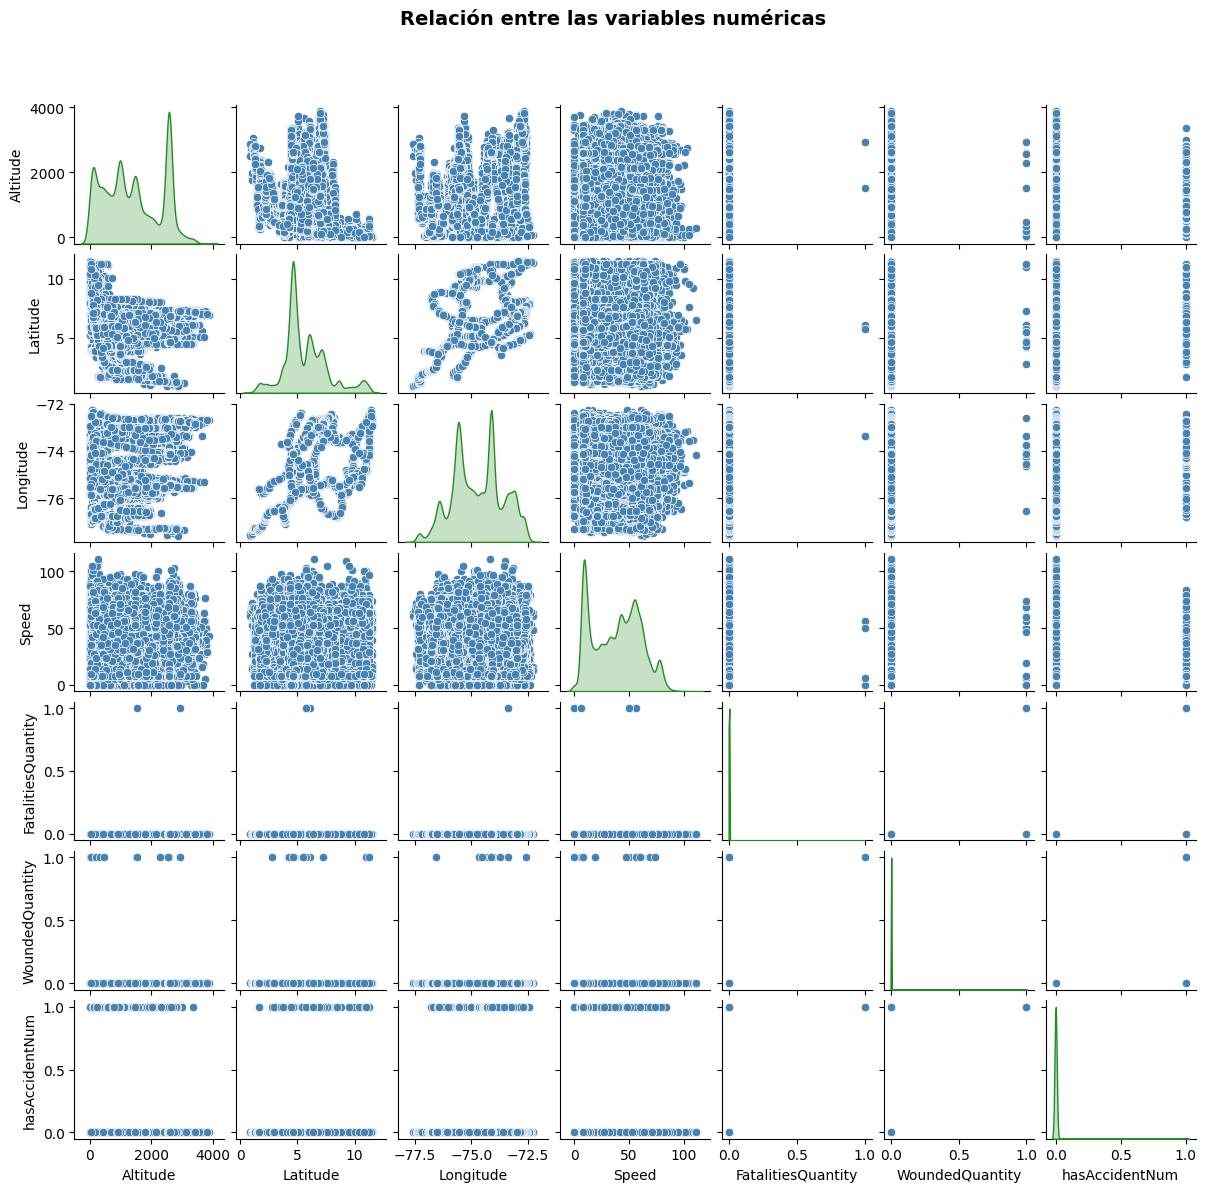

In [ ]:
# Visualización de variables numéricas
# =================================================================
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [ ]:
# utilización de LocalOutlierFactor con 20 vecinos para identificar valores atípicos en las variables de entrada
# ==============================================================================

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# identificar los valores atípicos por medio de lof
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())
print(df.shape)

# Eliminar los valores atípicos del dataframe original
df1 = df.loc[~outliers]

df1.shape


Indices de valores atípicos:  [6, 16, 30, 33, 36, 58, 66, 72, 74, 78, 83, 84, 85, 86, 87, 88, 90, 91, 92, 99, 100, 108, 110, 111, 113, 115, 122, 127, 134, 143, 146, 148, 149, 153, 163, 164, 167, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 194, 195, 196, 197, 200, 203, 209, 211, 214, 216, 220, 236, 237, 238, 239, 240, 246, 248, 258, 267, 268, 271, 274, 275, 276, 278, 280, 281, 282, 283, 284, 285, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 311, 312, 313, 314, 315, 316, 321, 323, 324, 356, 358, 364, 365, 374, 376, 381, 382, 383, 384, 385, 386, 391, 397, 400, 402, 405, 406, 409, 412, 419, 420, 421, 430, 435, 436, 438, 445, 446, 447, 449, 450, 455, 467, 473, 475, 479, 481, 483, 484, 485, 487, 488, 489, 490, 493, 494, 498, 501, 503, 504, 505, 506, 507, 508, 510, 511, 513, 514, 515, 516, 517, 521, 522, 533, 534, 536, 537, 540, 544, 545, 546, 551, 552, 553, 554, 556, 562, 563, 574, 575, 576, 580, 581, 588, 589, 

(69213, 23)

In [ ]:
# Calculo y eliminación de valores atípicos
# ==============================================================================

#Calculo de Q1 t Q3
Q1 = np.percentile(df[y], 25, interpolation = 'midpoint')
Q3 = np.percentile(df[y], 75, interpolation = 'midpoint')

IQR = Q3 - Q1

VAInf = Q1 - 1.5*IQR
VASup = Q3 + 1.5*IQR

print(f'Valor atípico leve inferior:{VAInf}')
print(f'Valor atípico leve superior:{VASup}')

# Se eliminan los valores atípicos
df_event = df.drop(df[df[y]>VASup].index)
df.reset_index(drop=True, inplace=True)

df.shape

Valor atípico leve inferior:0.0
Valor atípico leve superior:0.0


(76904, 23)

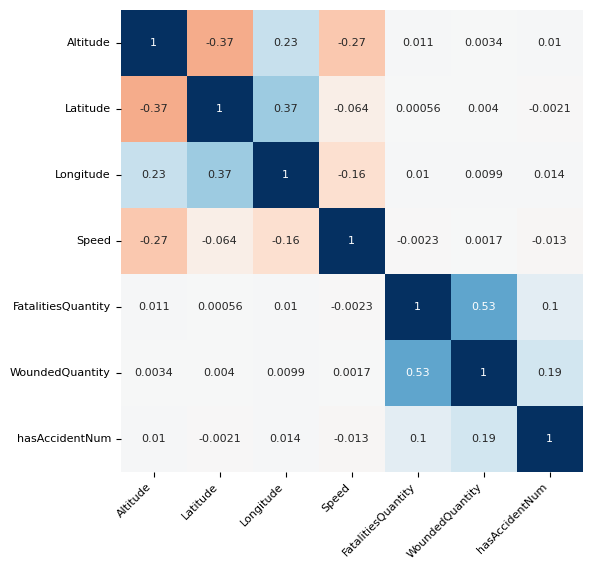

In [ ]:
# Generación de la matriz de correlación y su mapa de calor
# =================================================================
matrizCorr = df[numCols].corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


ax.tick_params(labelsize = 8)

In [ ]:
# validación de normalización variabe de salida
# ==============================================================================
y = 'hasAccidentNum'
df[y].value_counts(normalize=True)

,proportion
hasAccidentNum,
0,0.993823
1,0.006177


Dado el desbalance significativo de la variable de salida hasAccidentNum, donde la clase "1" (con accidente) es solo el 0.6% de los datos, planteamos para avanzar en el modelado evaluar si es necesario técnicas de balanceo para mejorar el rendimiento.
 Sobremuestreo de la clase minoritaria o SMOTE. Submuestreo de la clase mayoritaria inviable para el dataset.